In [ ]:
import boto3
from datetime import datetime

# Print execution info
print(f"Execution started at: {datetime.now()}")

# Get current IAM role
sts = boto3.client('sts')
identity = sts.get_caller_identity()
print(f"Current Role ARN: {identity['Arn']}")
print(f"Account ID: {identity['Account']}")

In [ ]:
import os
print(f"IMAGE_VERSION: {os.environ.get('IMAGE_VERSION', 'Not set')}")
print(f"SAGEMAKER_INTERNAL_IMAGE_URI: {os.environ.get('SAGEMAKER_INTERNAL_IMAGE_URI', 'Not set')}")

In [ ]:
from datetime import datetime
from zoneinfo import ZoneInfo
print(f"Execution Start Time (EST): {datetime.now(ZoneInfo('America/New_York')).strftime('%Y-%m-%d %H:%M:%S %Z')}")

In [ ]:
# Package upgrade skipped - using environment default
print('Using default sagemaker_studio package from environment')

# Test 06: Customer Purchase Analytics using DuckDB

This notebook performs data analytics on customer purchase data to identify key features and trends

In [0]:
from sagemaker_studio import sqlutils

In [0]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Create synthetic customer purchase data
n_customers = 1000
customers = pd.DataFrame({
    "customer_id": np.arange(1, n_customers + 1),
    "age": np.random.randint(18, 70, size=n_customers),
    "gender": np.random.choice(["Male", "Female"], size=n_customers),
    "annual_income": np.random.normal(70000, 15000, n_customers).round(2),
    "spending_score": np.random.randint(1, 100, n_customers),
    "purchase_count": np.random.poisson(15, n_customers),
    "avg_purchase_value": np.random.uniform(20, 500, n_customers).round(2),
    "churned": np.random.choice([0, 1], size=n_customers, p=[0.8, 0.2])
})

customers["total_spent"] = (customers["purchase_count"] * customers["avg_purchase_value"]).round(2)
customers.head()

,customer_id,age,gender,annual_income,spending_score,purchase_count,avg_purchase_value,churned,total_spent
0,1,56,Male,69753.66,11,17,490.90,0,8345.30
1,2,69,Male,87825.90,49,16,337.67,1,5402.72
2,3,46,Male,107903.99,38,22,412.11,0,9066.42
3,4,32,Female,62036.97,64,14,379.78,0,5316.92
4,5,60,Male,62658.41,69,14,355.78,1,4980.92


In [0]:
sql_output_aixx = sqlutils.sql("SELECT COUNT(*) AS total_customers FROM customers")
sql_output_aixx

,total_customers
0,1000


In [0]:
sql_output_4rnb = sqlutils.sql("SELECT \n    COUNT(*) AS total_customers,\n    AVG(age) AS avg_age,\n    AVG(annual_income) AS avg_income,\n    AVG(total_spent) AS avg_spent,\n    SUM(churned) AS churned_customers\nFROM customers;")
sql_output_4rnb

,total_customers,avg_age,avg_income,avg_spent,churned_customers
0,1000,43.819,71204.48724,3811.21248,205.0


In [0]:
sql_output_avi8 = sqlutils.sql("SELECT \n    gender,\n    ROUND(AVG(annual_income), 2) AS avg_income,\n    ROUND(AVG(spending_score), 2) AS avg_spending_score,\n    ROUND(AVG(total_spent), 2) AS avg_total_spent\nFROM customers\nGROUP BY gender\nORDER BY avg_total_spent DESC;")
sql_output_avi8

,gender,avg_income,avg_spending_score,avg_total_spent
0,Female,70750.44,50.09,3864.88
1,Male,71616.94,50.18,3762.46


2025-11-01 22:35:06,218 - matplotlib.font_manager - INFO - generated new fontManager


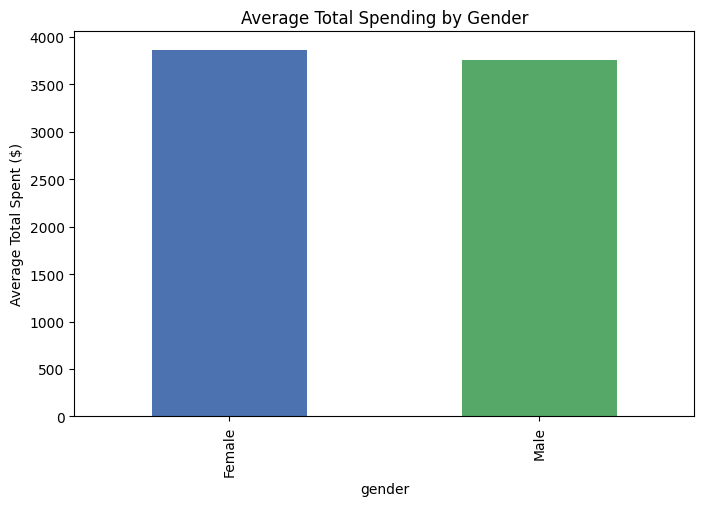

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
customers.groupby("gender")["total_spent"].mean().plot(kind="bar", color=["#4C72B0", "#55A868"])
plt.title("Average Total Spending by Gender")
plt.ylabel("Average Total Spent ($)")
plt.show()

In [0]:
sql_output_cciq = sqlutils.sql("SELECT *\nFROM customers\nWHERE total_spent > (\n    SELECT PERCENTILE_CONT(0.9) WITHIN GROUP (ORDER BY total_spent) FROM customers\n)\nORDER BY total_spent DESC;")
sql_output_cciq

,customer_id,age,gender,annual_income,spending_score,purchase_count,avg_purchase_value,churned,total_spent
0,330,19,Male,60056.49,44,26,482.95,1,12556.70
1,603,53,Female,80835.72,76,25,461.90,0,11547.50
2,170,60,Female,46354.12,42,23,477.36,1,10979.28
3,908,34,Female,48136.73,23,21,492.03,1,10332.63
4,274,50,Female,37699.15,72,21,491.48,0,10321.08
...,...,...,...,...,...,...,...,...,...
95,763,27,Male,70363.29,62,15,478.41,0,7176.15
96,530,53,Male,92520.00,11,17,421.84,0,7171.28
97,565,54,Female,72715.32,69,21,339.51,0,7129.71
98,701,34,Male,58981.13,17,20,355.20,0,7104.00


In [0]:
sql_output_6pi2 = sqlutils.sql("SELECT \n    CASE \n        WHEN total_spent < 2000 THEN 'Low Spender'\n        WHEN total_spent BETWEEN 2000 AND 6000 THEN 'Medium Spender'\n        ELSE 'High Spender'\n    END AS spending_tier,\n    COUNT(*) AS num_customers,\n    ROUND(AVG(annual_income), 2) AS avg_income\nFROM customers\nGROUP BY spending_tier\nORDER BY num_customers DESC;")
sql_output_6pi2

,spending_tier,num_customers,avg_income
0,Medium Spender,542,71201.41
1,Low Spender,273,70627.53
2,High Spender,185,72064.90


In [0]:
sql_output_dk2q = sqlutils.sql("SELECT \n    CASE \n        WHEN total_spent < 2000 THEN 'Low Spender'\n        WHEN total_spent BETWEEN 2000 AND 6000 THEN 'Medium Spender'\n        ELSE 'High Spender'\n    END AS spending_tier,\n    COUNT(*) AS num_customers\nFROM customers\nGROUP BY spending_tier")
sql_output_dk2q

,spending_tier,num_customers
0,Low Spender,273
1,High Spender,185
2,Medium Spender,542


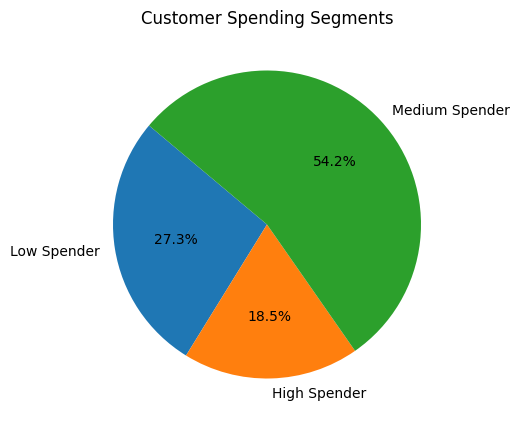

In [0]:
plt.figure(figsize=(7,5))
plt.pie(sql_output_dk2q["num_customers"], labels=sql_output_dk2q["spending_tier"], autopct="%1.1f%%", startangle=140)
plt.title("Customer Spending Segments")
plt.show()

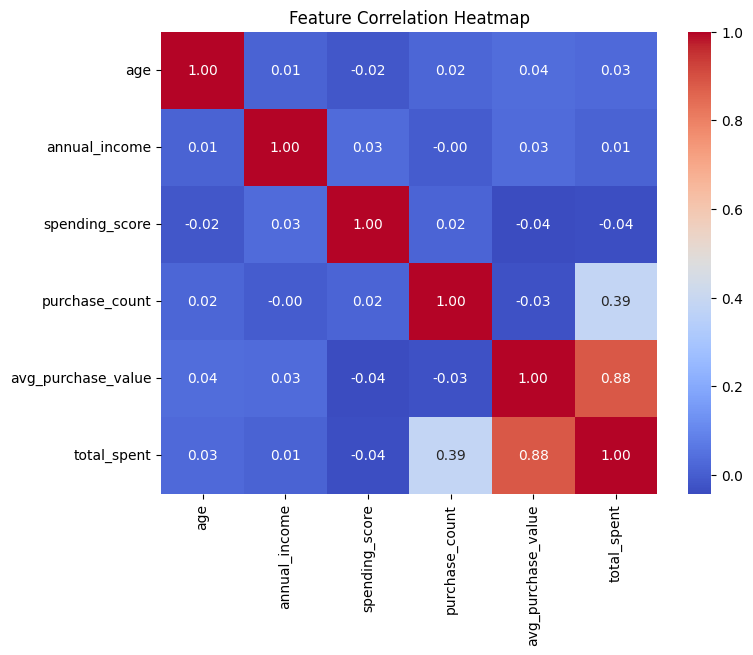

In [0]:
import seaborn as sns

corr = customers[["age", "annual_income", "spending_score", "purchase_count", "avg_purchase_value", "total_spent"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = df[["age", "annual_income", "spending_score", "purchase_count", "avg_purchase_value", "total_spent"]]
y = df["churned"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       165
           1       0.00      0.00      0.00        35

    accuracy                           0.79       200
   macro avg       0.41      0.48      0.44       200
weighted avg       0.68      0.79      0.73       200



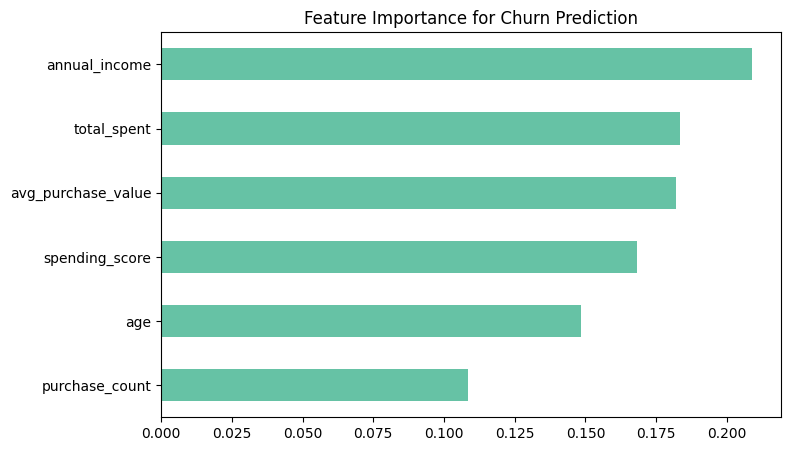

In [0]:
import numpy as np

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(8,5))
importances.plot(kind='barh', color="#66c2a5")
plt.title("Feature Importance for Churn Prediction")
plt.show()

In [0]:
churn_results = pd.DataFrame({
    "customer_id": X_test.index,
    "actual": y_test.values,
    "predicted": y_pred
})

In [0]:
sql_output_3n8o = sqlutils.sql("SELECT \n    COUNT(*) AS total_tested,\n    SUM(predicted) AS predicted_churns,\n    SUM(CASE WHEN actual = predicted THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS accuracy\nFROM churn_results")
sql_output_3n8o

,total_tested,predicted_churns,accuracy
0,200,7.0,79.0
